# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
# !./download_data.sh

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [5]:
X.shape

NameError: name 'X' is not defined

In [6]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [7]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [35]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for fc1_W
Gradient check passed!
Checking gradient for fc1_B
Gradient check passed!
Checking gradient for fc2_W
Gradient check passed!
Checking gradient for fc2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [36]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for fc1_W
Gradient check passed!
Checking gradient for fc1_B
Gradient check passed!
Checking gradient for fc2_W
Gradient check passed!
Checking gradient for fc2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [51]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

#0.1, так как количество классов = 10. 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [54]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302446, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.301769, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302113, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.301477, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302177, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302148, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.301415, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302803, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301005, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302052, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302110, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302246, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302364, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.301510, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303201, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302023, Train acc

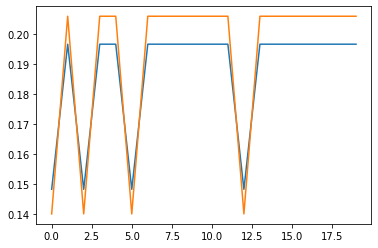

In [55]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [56]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.279816, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276095, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302537, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.261553, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.258660, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.199851, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.252869, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.316060, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.261071, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294550, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.213962, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.328531, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265298, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300449, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279637, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.326617, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [67]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.89)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.322298, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321196, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320152, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288661, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301428, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274276, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291370, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303885, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270436, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.316613, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298564, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.261651, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301345, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.316311, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319727, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288807, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [68]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.331153, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319485, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.310202, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.294249, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.267769, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.310169, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.272425, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.230343, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.079480, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.192102, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.333190, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.397284, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.707860, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.136497, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.780975, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.959194, Train acc

Loss: 1.133824, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.622532, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.126915, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.504876, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.308758, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.242236, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.316953, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.127420, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.336672, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.326583, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.391557, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.242850, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.171301, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.321793, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.568719, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.568855, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [82]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 1000, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=2e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.314016, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.270437, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.277316, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.062609, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.684136, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.849816, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 1.301826, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 1.727921, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.615777, Train accuracy: 0.600000, val accuracy: 0.133333
Loss: 1.241614, Train accuracy: 0.466667, val accuracy: 0.133333
Loss: 1.549091, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 1.273008, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 1.217543, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 0.891656, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 0.367313, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 1.070984, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [96]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-3
reg_strength = 1e-2
learning_rate_decay = 0.99
hidden_layer_size = 1024
num_epochs = 350
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rates, num_epochs=num_epochs, batch_size=batch_size, learning_rate_decay=learning_rate_decay)

loss_history, train_history, val_history = trainer.fit()
best_val_accuracy = max(val_history)

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch: 0, Loss: 2.313215, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 1, Loss: 2.271794, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 2, Loss: 2.243684, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 3, Loss: 2.198240, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 4, Loss: 2.189183, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 5, Loss: 2.226161, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 6, Loss: 2.314014, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 7, Loss: 2.290646, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 8, Loss: 2.198725, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 9, Loss: 2.305571, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 10, Loss: 2.269494, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 11, Loss: 2.224045, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 12, Loss: 2.098623, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch: 13, Loss: 2.304

Epoch: 108, Loss: 1.949311, Train accuracy: 0.450333, val accuracy: 0.441000
Epoch: 109, Loss: 1.995691, Train accuracy: 0.451333, val accuracy: 0.442000
Epoch: 110, Loss: 1.796316, Train accuracy: 0.454333, val accuracy: 0.445000
Epoch: 111, Loss: 1.957700, Train accuracy: 0.454444, val accuracy: 0.443000
Epoch: 112, Loss: 1.940085, Train accuracy: 0.455889, val accuracy: 0.446000
Epoch: 113, Loss: 1.950080, Train accuracy: 0.457778, val accuracy: 0.451000
Epoch: 114, Loss: 1.829501, Train accuracy: 0.459333, val accuracy: 0.452000
Epoch: 115, Loss: 2.009002, Train accuracy: 0.460444, val accuracy: 0.453000
Epoch: 116, Loss: 1.723678, Train accuracy: 0.462333, val accuracy: 0.456000
Epoch: 117, Loss: 1.921634, Train accuracy: 0.463778, val accuracy: 0.459000
Epoch: 118, Loss: 1.873470, Train accuracy: 0.466667, val accuracy: 0.461000
Epoch: 119, Loss: 1.975975, Train accuracy: 0.467333, val accuracy: 0.456000
Epoch: 120, Loss: 1.882789, Train accuracy: 0.467889, val accuracy: 0.463000

Epoch: 215, Loss: 1.756757, Train accuracy: 0.535333, val accuracy: 0.544000
Epoch: 216, Loss: 1.789471, Train accuracy: 0.536111, val accuracy: 0.542000
Epoch: 217, Loss: 1.763937, Train accuracy: 0.536000, val accuracy: 0.544000
Epoch: 218, Loss: 1.646639, Train accuracy: 0.536889, val accuracy: 0.539000
Epoch: 219, Loss: 1.711820, Train accuracy: 0.537222, val accuracy: 0.541000
Epoch: 220, Loss: 1.823619, Train accuracy: 0.537000, val accuracy: 0.542000
Epoch: 221, Loss: 1.682347, Train accuracy: 0.537111, val accuracy: 0.543000
Epoch: 222, Loss: 1.891623, Train accuracy: 0.537333, val accuracy: 0.541000
Epoch: 223, Loss: 1.905200, Train accuracy: 0.537111, val accuracy: 0.542000
Epoch: 224, Loss: 1.826172, Train accuracy: 0.537667, val accuracy: 0.545000
Epoch: 225, Loss: 1.934972, Train accuracy: 0.538000, val accuracy: 0.544000
Epoch: 226, Loss: 1.675747, Train accuracy: 0.538778, val accuracy: 0.542000
Epoch: 227, Loss: 1.835156, Train accuracy: 0.539000, val accuracy: 0.543000

Epoch: 322, Loss: 1.754462, Train accuracy: 0.560778, val accuracy: 0.561000
Epoch: 323, Loss: 1.947542, Train accuracy: 0.560778, val accuracy: 0.560000
Epoch: 324, Loss: 1.924437, Train accuracy: 0.560444, val accuracy: 0.561000
Epoch: 325, Loss: 1.715731, Train accuracy: 0.560667, val accuracy: 0.561000
Epoch: 326, Loss: 1.812885, Train accuracy: 0.561222, val accuracy: 0.561000
Epoch: 327, Loss: 1.625511, Train accuracy: 0.561222, val accuracy: 0.561000
Epoch: 328, Loss: 1.912723, Train accuracy: 0.561333, val accuracy: 0.561000
Epoch: 329, Loss: 1.662766, Train accuracy: 0.561556, val accuracy: 0.561000
Epoch: 330, Loss: 1.616348, Train accuracy: 0.561556, val accuracy: 0.561000
Epoch: 331, Loss: 1.473631, Train accuracy: 0.561333, val accuracy: 0.561000
Epoch: 332, Loss: 1.575134, Train accuracy: 0.561556, val accuracy: 0.561000
Epoch: 333, Loss: 1.699645, Train accuracy: 0.561444, val accuracy: 0.561000
Epoch: 334, Loss: 2.076673, Train accuracy: 0.561333, val accuracy: 0.561000

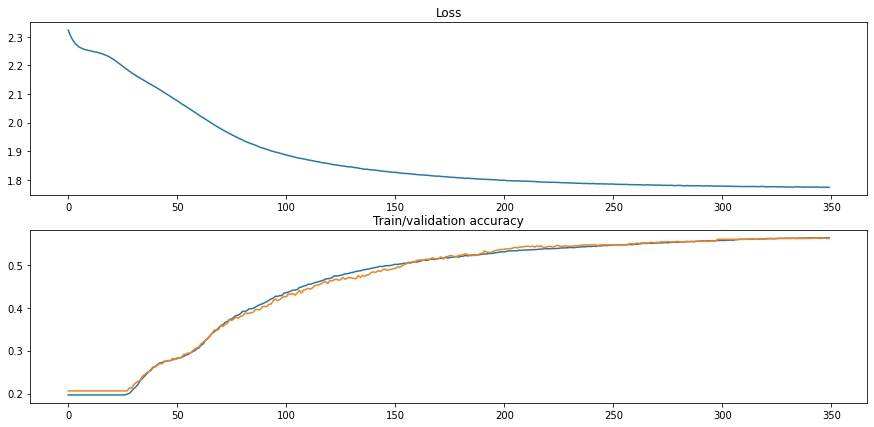

In [97]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [100]:
test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.514000
